In [1]:
import numpy as np
import pandas as pd
import torch
from snntorch import spikegen
from SmartHandDataset import SmartHandDataset
from utils import get_palm_mask_484, get_true_indices, convert_to_spikes, spike_times_to_tensor
import matplotlib.pyplot as plt
# ---- Paths (edit as needed)
MAT_PATH = "smarthand_dataset.mat"
RANK_CSV = "res95_ranked_taxels.csv"   # produced by your PCA+Pearson script
TOPN = 300
NUM_FRAMES = 1000  # number of time frames to encode each sample
NUM_TRAIN = 800  # number of frames for training
NUM_TEST = 200   # number of frames for testing
THRESHOLD = 0.03  # threshold for delta modulation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
rank_df = pd.read_csv(RANK_CSV)
topN_idx = rank_df["Orig_idx"].to_numpy()[:TOPN]

palm_mask = get_true_indices(get_palm_mask_484())
balanced_dataset = SmartHandDataset(
    mat_path=MAT_PATH,
    valid_only=True,
    subtract_baseline=True,
    hand_mask=palm_mask,
    exclude_empty_hand=False,
    verbose=False,
    num_frames=None,
    normalize='full'
)
X, y, z = balanced_dataset.as_matrix()

Computed num_frames as minimum available: 1153
Num frames: 1153, Num sessions: 5, Num classes: 17
Final X shape: (85, 1153, 484), y length: 85, z length: 85


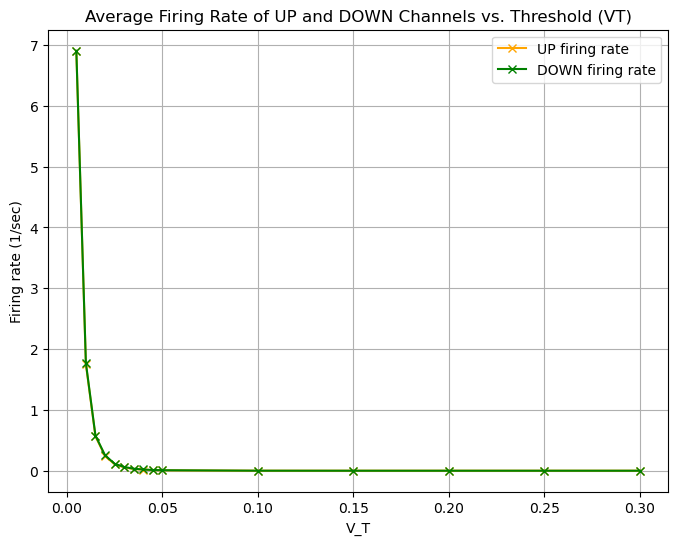

In [5]:
# Parameters
SAMPLING_RATE = 100  # Hz, from ETH SmartHand dataset paper
vt_low = np.arange(0.005, 0.05, 0.005)  # Finer steps before 0.005: 0.0, 0.001, ..., 0.004
vt_coarse = np.arange(0.05, 0.301, 0.05)  # Less often after 0.05: step 0.02, up to 0.30
vt_values = np.sort(np.unique(np.concatenate([vt_low, vt_coarse])))  # Combine and sort unique
up_rates = []  # To store UP firing rates
down_rates = []  # To store DOWN firing rates

# Prepare data: Transpose X to [num_frames, n_pairs, n_features] = [1000, 85, 300]
X_tensor = torch.from_numpy(X.astype(np.float32)).to(device)
X_tensor = X_tensor.permute(1, 0, 2)  # [1000, 85, 300]

# Loop over each VT to compute spikes and rates
for vt in vt_values:
    # Compute spikes with current threshold
    spikes = spikegen.delta(X_tensor, threshold=vt, padding=True, off_spike=True)  # [1000, 85, 300]
    
    # Separate UP (positive spikes) and DOWN (negative spikes, absolute count)
    up_spikes = (spikes > 0).float()  # [1000, 85, 300], 1 where UP spike
    down_spikes = (spikes < 0).float()  # [1000, 85, 300], 1 where DOWN spike
    
    # Average spikes per frame (mean over time dim=0)
    avg_up_per_frame = up_spikes.mean(dim=0)  # [85, 300]
    avg_down_per_frame = down_spikes.mean(dim=0)  # [85, 300]
    
    # Overall average per frame across all sequences and taxels
    overall_avg_up = avg_up_per_frame.mean()  # Scalar
    overall_avg_down = avg_down_per_frame.mean()  # Scalar
    
    # Convert to firing rate (spikes/sec)
    up_rate = overall_avg_up.item() * SAMPLING_RATE
    down_rate = overall_avg_down.item() * SAMPLING_RATE
    
    up_rates.append(up_rate)
    down_rates.append(down_rate)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(vt_values, up_rates, marker='x', color='orange', label='UP firing rate')
plt.plot(vt_values, down_rates, marker='x', color='green', label='DOWN firing rate')
plt.xlabel('V_T')
plt.ylabel('Firing rate (1/sec)')
plt.title('Average Firing Rate of UP and DOWN Channels vs. Threshold (VT)')
plt.legend()
plt.grid(True)
plt.show()